# Designing larger simulation data

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
import random

# print directory
import os
print(os.getcwd())
os.chdir("../..")
print(os.getcwd())

from src.models.sparse_autoencoder import *
from src.visualization.plotting import *

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# set a random seed
seed = 0

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

/home/dbm829/projects/interpreting_omics_models/02_experiments/simulation
/home/dbm829/projects/interpreting_omics_models


In [2]:
data_dir = '/projects/heads/data/simulation/singlecell/'

## Generate a larger and more complex simulated dataset

### test

In [4]:
y_dim = 20000
x_dim = 100

n_celltypes = [10, 40]
n_covariates = [1, 10]

n_cells = 1e9 # I will subsample later
n_cells = 100

In [5]:
program_id = 0

# adjacency matrices (binary)
p_xy = 0.1
xy = torch.tensor(np.random.binomial(1, p_xy, (x_dim, y_dim))).float()
p_ctx = 0.7
cx = torch.tensor(np.random.binomial(1, p_ctx, (n_celltypes[program_id], x_dim))).float()
if n_covariates[program_id] == 1:
    cxo = torch.ones(n_covariates[program_id], x_dim)
else:
    p_cox = 0.2
    cxo = torch.tensor(np.random.binomial(1, p_cox, (n_covariates[program_id], x_dim))).float()

# distributions for the choice of categorical variables
p_ct = torch.distributions.categorical.Categorical(1/n_celltypes[program_id]*torch.ones(n_celltypes[program_id]))
p_co = torch.distributions.categorical.Categorical(1/n_covariates[program_id]*torch.ones(n_covariates[program_id]))

# sample activity is a poisson
poisson_lambda = 1.0
# get x many slightly different poisson lambdas
poisson_lambdas = torch.tensor([poisson_lambda + 0.1 * i for i in range(x_dim)])
activity_distribution = torch.distributions.poisson.Poisson(poisson_lambdas)

# distribution for sample noise
p_noise = 0.1
noise_distribution = torch.distributions.bernoulli.Bernoulli(p_noise)

###
# sampling
###

# sample activities
print('Generating ct specific activities of biological programs')
x_0 = activity_distribution.sample((n_cells,)).unsqueeze(1)
# sample cell type identities and create ct-specific activities
ct = p_ct.sample((n_cells,)) # indices of which ct to use
x_1 = x_0 * cx.unsqueeze(0)
x_1 = x_1[torch.arange(n_cells), ct]
print(x_0.shape, cx.unsqueeze(0).shape, x_1.shape)

print('Generating covariate-specific activities')
co = p_co.sample((n_cells,))
x_2 = x_1.unsqueeze(1) * cxo.unsqueeze(0)
x_2 = x_2[torch.arange(n_cells), co]
print(x_1.unsqueeze(1).shape, cxo.unsqueeze(0).shape, x_2.shape)

# create observable data
print('Generating observable data Y')
y = xy.unsqueeze(0) * x_2.unsqueeze(2)
y = y.sum(1)
print(xy.unsqueeze(0).shape, x_2.unsqueeze(2).shape, y.shape)

Generating ct specific activities of biological programs
torch.Size([100, 1, 100]) torch.Size([1, 10, 100]) torch.Size([100, 100])
Generating covariate-specific activities
torch.Size([100, 1, 100]) torch.Size([1, 1, 100]) torch.Size([100, 100])
Generating observable data Y
torch.Size([1, 100, 20000]) torch.Size([100, 100, 1]) torch.Size([100, 20000])


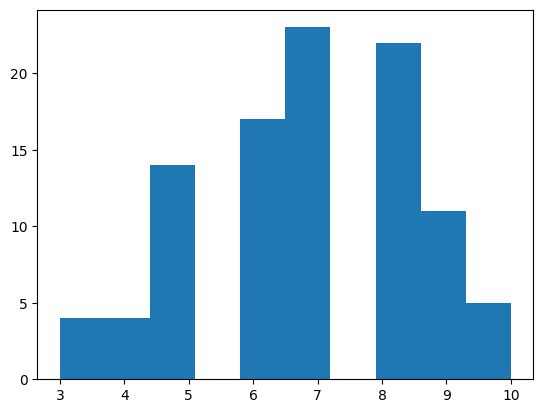

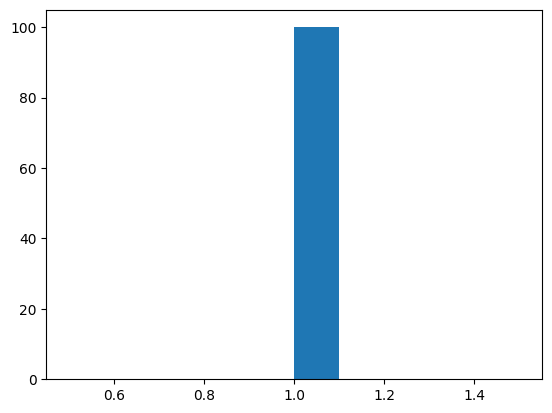

In [6]:
plt.hist(cx.sum(0))
plt.show()

plt.hist(cxo.sum(0))
plt.show()

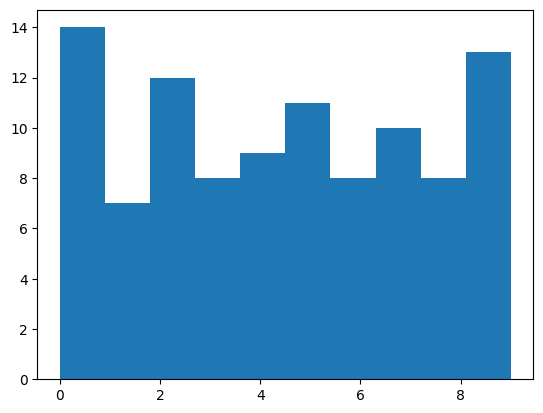

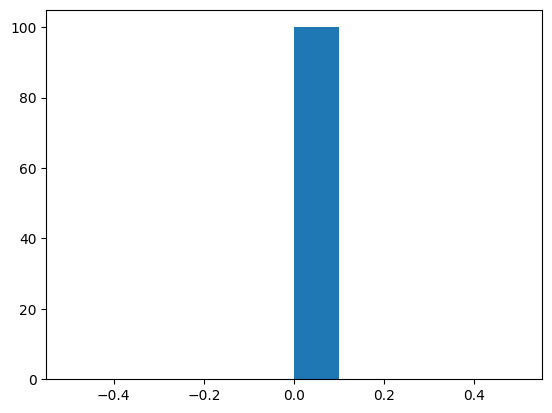

In [7]:
plt.hist(ct.flatten().numpy())
plt.show()

plt.hist(co.flatten().numpy())
plt.show()

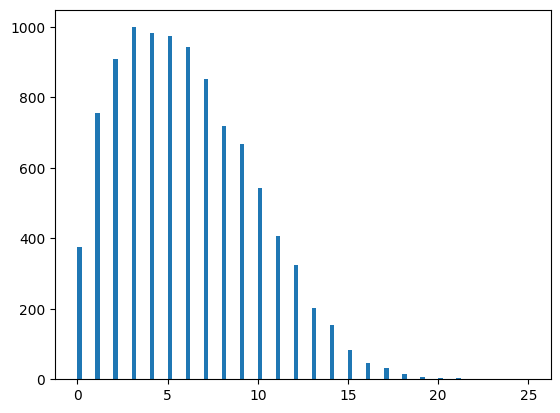

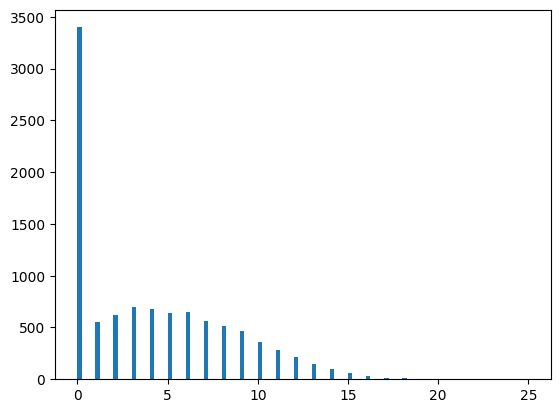

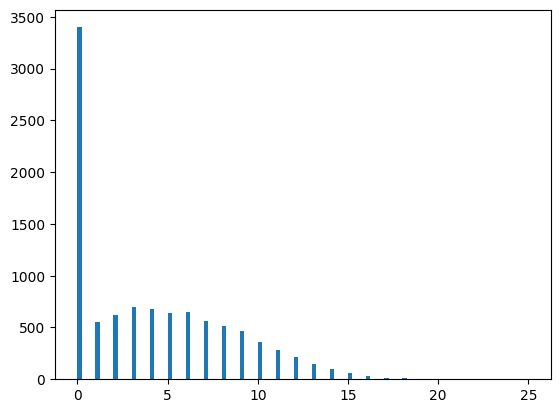

In [8]:
plt.hist(x_0.flatten().numpy(), bins=100)
plt.show()

plt.hist(x_1.flatten().numpy(), bins=100)
plt.show()

plt.hist(x_2.flatten().numpy(), bins=100)
plt.show()

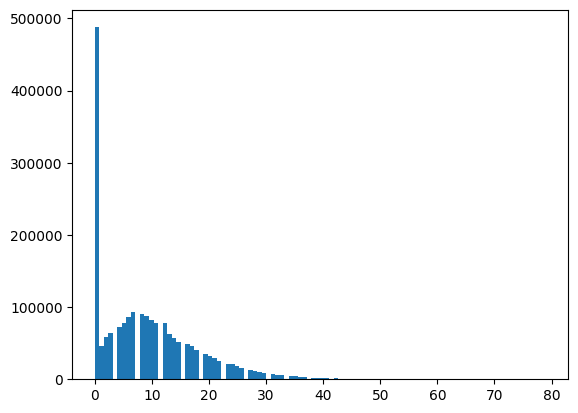

In [7]:
plt.hist(y.flatten(), bins=100)
plt.show()

In [9]:
# make a pca of x and y and color by ct

from sklearn.decomposition import PCA
import seaborn as sns

pca = PCA(n_components=2)
x_pca = pca.fit_transform(x_2.detach().numpy())
y_pca = pca.fit_transform(y.detach().numpy())

df_x = pd.DataFrame(x_pca, columns=['PC1', 'PC2'])
df_x['ct'] = ct
df_y = pd.DataFrame(y_pca, columns=['PC1', 'PC2'])
df_y['ct'] = ct

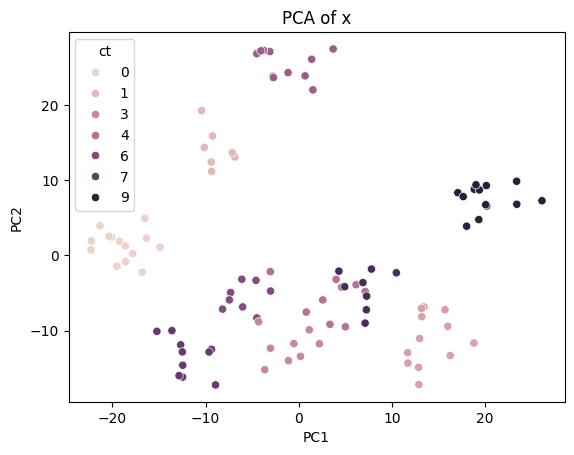

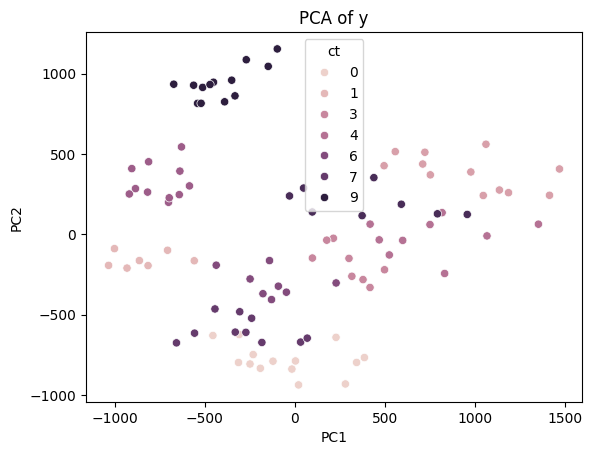

In [10]:
sns.scatterplot(data=df_x, x='PC1', y='PC2', hue='ct')
plt.title('PCA of x')
plt.show()

sns.scatterplot(data=df_y, x='PC1', y='PC2', hue='ct')
plt.title('PCA of y')
plt.show()

### function

In [3]:
def data_simulation(seed, y_dim, x_dim, n_ct, n_cov, n_cells, printing=False):
    # set the seed
    torch.manual_seed(0)
    torch.cuda.manual_seed(0)
    np.random.seed(0)
    random.seed(0)

    # adjacency matrices (binary)
    p_xy = 0.1
    xy = torch.tensor(np.random.binomial(1, p_xy, (x_dim, y_dim))).float()
    if n_cov == 1:
        p_ctx = 0.7
    else:
        p_ctx = 0.3
    cx = torch.tensor(np.random.binomial(1, p_ctx, (n_ct, x_dim))).float()
    if n_cov == 1:
        cxo = torch.ones(n_cov, x_dim)
    else:
        p_cox = 0.9
        cxo = torch.tensor(np.random.binomial(1, p_cox, (n_cov, x_dim))).float()

    # distributions for the choice of categorical variables
    p_ct = torch.distributions.categorical.Categorical(1/n_ct*torch.ones(n_ct))
    p_co = torch.distributions.categorical.Categorical(1/n_cov*torch.ones(n_cov))

    # sample activity is a poisson
    poisson_lambda = 1.0
    # get x many slightly different poisson lambdas
    poisson_lambdas = torch.tensor([poisson_lambda + 0.1 * i for i in range(x_dim)])
    activity_distribution = torch.distributions.poisson.Poisson(poisson_lambdas)

    # distribution for sample noise
    # random values between 0 and 1 for p_noise in shape n_cov
    #p_noise = torch.rand((n_cov, x_dim))
    #noise_distribution = torch.distributions.bernoulli.Bernoulli(p_noise)
    # n_cov many gaussians with different means
    noise_means = torch.tensor([1.0 * i for i in range(n_cov)])
    noise_distribution = torch.distributions.normal.Normal(noise_means, 0.1)

    ###
    # sampling
    ###
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    # sample activities
    x_0 = activity_distribution.sample((n_cells,))#.unsqueeze(1)

    if printing:
        print('Generating covariate-specific activities')
    co = p_co.sample((n_cells,))
    if n_cov == 1:
        #noise = noise_distribution.sample((n_cells, x_dim)) * 1e-6
        #co_noise = noise.unsqueeze(1) * cxo.unsqueeze(0)
        #x_1 = x_0.unsqueeze(1) + co_noise
        x_1 = x_0
    else:
        noise = noise_distribution.sample((n_cells,))# * 1e-3
        x_1 = x_0.unsqueeze(1) + noise.unsqueeze(-1)
        x_1 = x_1[torch.arange(n_cells), co]
    if printing:
        print(x_0.unsqueeze(1).shape, cxo.unsqueeze(0).shape, x_1.shape)
    
    if printing:
        print('Generating ct specific activities of biological programs')
    # sample cell type identities and create ct-specific activities
    ct = p_ct.sample((n_cells,)) # indices of which ct to use
    x_2 = x_1.unsqueeze(1) * cx.unsqueeze(0)
    x_2 = x_2[torch.arange(n_cells), ct]
    if printing:
        print(x_1.shape, cx.unsqueeze(0).shape, x_2.shape)

    # create observable data
    if printing:
        print('Generating observable data Y')
    y = xy.unsqueeze(0) * x_2.unsqueeze(2)
    y = y.sum(1)

    if printing:
        print(xy.unsqueeze(0).shape, x_2.unsqueeze(2).shape, y.shape)

    return y, x_0, x_1, x_2, ct, co

### full set

In [4]:
seed = 0
complexity = 'low'
n_ct = 10
n_cov = 1

y, x_0, x_1, x_2, ct, co = data_simulation(
    seed=0,
    y_dim=20000,
    x_dim=100,
    n_ct=n_ct,
    n_cov=n_cov,
    n_cells=10000,
    printing=True
)

torch.save(y, data_dir+'large_{}-complexity_rs{}_y.pt'.format(complexity, seed))
torch.save(x_0, data_dir+'large_{}-complexity_rs{}_x0.pt'.format(complexity, seed))
torch.save(x_1, data_dir+'large_{}-complexity_rs{}_x1.pt'.format(complexity, seed))
torch.save(x_2, data_dir+'large_{}-complexity_rs{}_x2.pt'.format(complexity, seed))
torch.save(ct, data_dir+'large_{}-complexity_rs{}_ct.pt'.format(complexity, seed))
torch.save(co, data_dir+'large_{}-complexity_rs{}_co.pt'.format(complexity, seed))

Generating covariate-specific activities
torch.Size([10000, 1, 100]) torch.Size([1, 1, 100]) torch.Size([10000, 100])
Generating ct specific activities of biological programs
torch.Size([10000, 100]) torch.Size([1, 10, 100]) torch.Size([10000, 100])
Generating observable data Y
torch.Size([1, 100, 20000]) torch.Size([10000, 100, 1]) torch.Size([10000, 20000])


In [5]:
# make a pca of x and y and color by ct

from sklearn.decomposition import PCA
import seaborn as sns

pca = PCA(n_components=2)
x_pca = pca.fit_transform(x_2.detach().numpy())
y_pca = pca.fit_transform(y.detach().numpy())

df_x = pd.DataFrame(x_pca, columns=['PC1', 'PC2'])
df_x['ct'] = ct
df_y = pd.DataFrame(y_pca, columns=['PC1', 'PC2'])
df_y['ct'] = ct

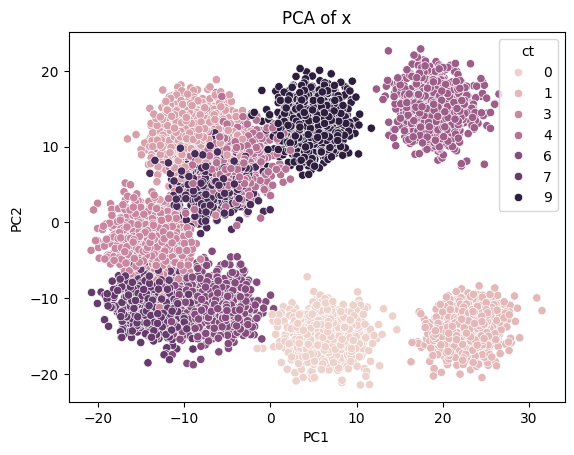

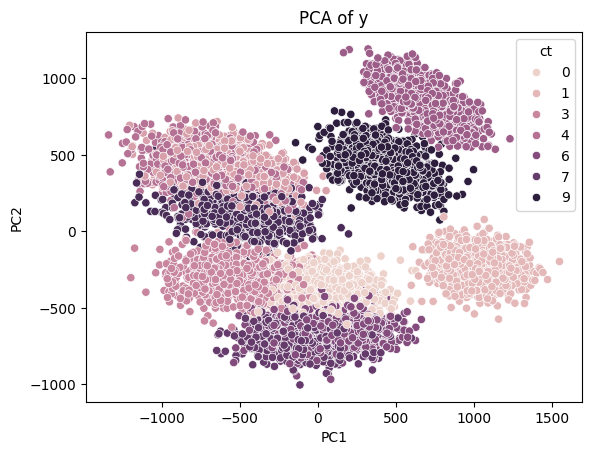

In [6]:
sns.scatterplot(data=df_x, x='PC1', y='PC2', hue='ct')
plt.title('PCA of x')
plt.show()

sns.scatterplot(data=df_y, x='PC1', y='PC2', hue='ct')
plt.title('PCA of y')
plt.show()

In [7]:
for i in range(1,10):
    seed = i
    complexity = 'low'
    n_ct = 10
    n_cov = 1

    y, x_0, x_1, x_2, ct, co = data_simulation(
        seed=seed,
        y_dim=20000,
        x_dim=100,
        n_ct=n_ct,
        n_cov=n_cov,
        n_cells=10000
    )

    torch.save(y, data_dir+'large_{}-complexity_rs{}_y.pt'.format(complexity, seed))
    torch.save(x_0, data_dir+'large_{}-complexity_rs{}_x0.pt'.format(complexity, seed))
    torch.save(x_1, data_dir+'large_{}-complexity_rs{}_x1.pt'.format(complexity, seed))
    torch.save(x_2, data_dir+'large_{}-complexity_rs{}_x2.pt'.format(complexity, seed))
    torch.save(ct, data_dir+'large_{}-complexity_rs{}_ct.pt'.format(complexity, seed))
    torch.save(co, data_dir+'large_{}-complexity_rs{}_co.pt'.format(complexity, seed))

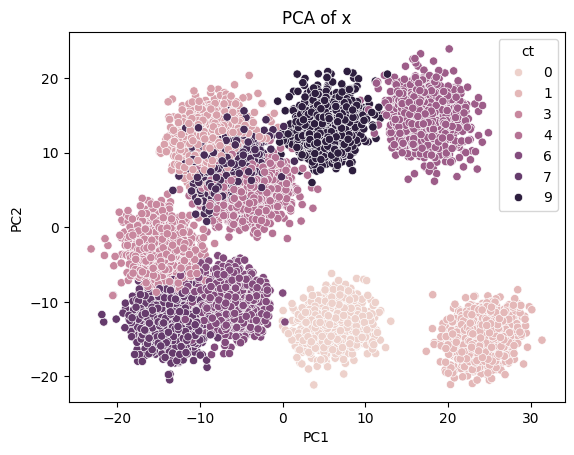

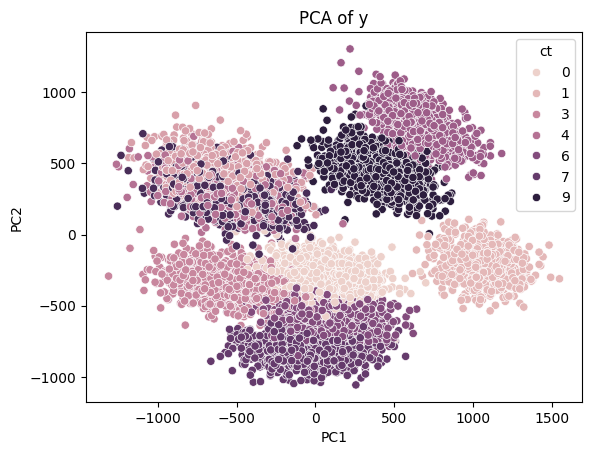

In [8]:
# make a pca of x and y and color by ct

from sklearn.decomposition import PCA
import seaborn as sns

pca = PCA(n_components=2)
x_pca = pca.fit_transform(x_2.detach().numpy())
y_pca = pca.fit_transform(y.detach().numpy())

df_x = pd.DataFrame(x_pca, columns=['PC1', 'PC2'])
df_x['ct'] = ct
df_y = pd.DataFrame(y_pca, columns=['PC1', 'PC2'])
df_y['ct'] = ct

sns.scatterplot(data=df_x, x='PC1', y='PC2', hue='ct')
plt.title('PCA of x')
plt.show()

sns.scatterplot(data=df_y, x='PC1', y='PC2', hue='ct')
plt.title('PCA of y')
plt.show()

### higher complexity

In [9]:
for i in range(0,10):
    seed = i
    complexity = 'high'
    n_ct = 40
    n_cov = 3

    y, x_0, x_1, x_2, ct, co = data_simulation(
        seed=seed,
        y_dim=20000,
        x_dim=100,
        n_ct=n_ct,
        n_cov=n_cov,
        n_cells=10000
    )

    torch.save(y, data_dir+'large_{}-complexity_rs{}_y.pt'.format(complexity, seed))
    torch.save(x_0, data_dir+'large_{}-complexity_rs{}_x0.pt'.format(complexity, seed))
    torch.save(x_1, data_dir+'large_{}-complexity_rs{}_x1.pt'.format(complexity, seed))
    torch.save(x_2, data_dir+'large_{}-complexity_rs{}_x2.pt'.format(complexity, seed))
    torch.save(ct, data_dir+'large_{}-complexity_rs{}_ct.pt'.format(complexity, seed))
    torch.save(co, data_dir+'large_{}-complexity_rs{}_co.pt'.format(complexity, seed))

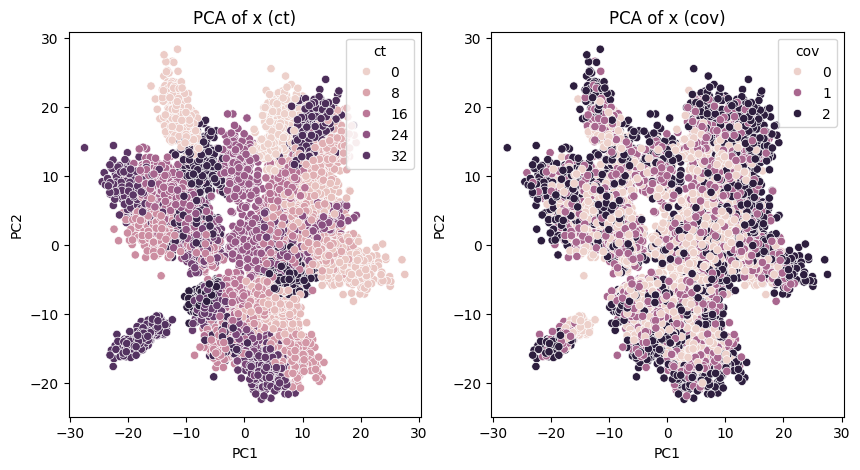

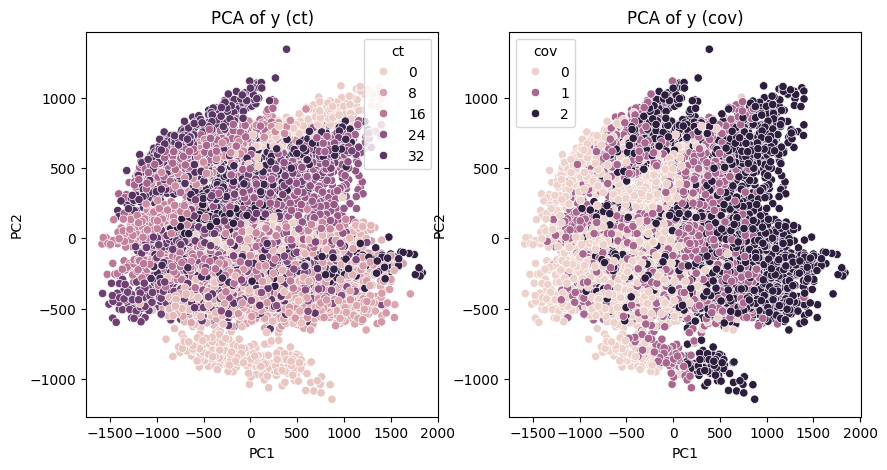

In [10]:
# make a pca of x and y and color by ct

from sklearn.decomposition import PCA
import seaborn as sns

pca = PCA(n_components=2)
x_pca = pca.fit_transform(x_2.detach().numpy())
y_pca = pca.fit_transform(y.detach().numpy())

df_x = pd.DataFrame(x_pca, columns=['PC1', 'PC2'])
df_x['ct'] = ct
df_x['cov'] = co
df_y = pd.DataFrame(y_pca, columns=['PC1', 'PC2'])
df_y['ct'] = ct
df_y['cov'] = co

fig, ax = plt.subplots(1,2, figsize=(10,5))
sns.scatterplot(data=df_x, x='PC1', y='PC2', hue='ct', ax=ax[0])
ax[0].set_title('PCA of x (ct)')
sns.scatterplot(data=df_x, x='PC1', y='PC2', hue='cov', ax=ax[1])
ax[1].set_title('PCA of x (cov)')
plt.show()

fig, ax = plt.subplots(1,2, figsize=(10,5))
sns.scatterplot(data=df_y, x='PC1', y='PC2', hue='ct', ax=ax[0])
ax[0].set_title('PCA of y (ct)')
sns.scatterplot(data=df_y, x='PC1', y='PC2', hue='cov', ax=ax[1])
ax[1].set_title('PCA of y (cov)')
plt.show()

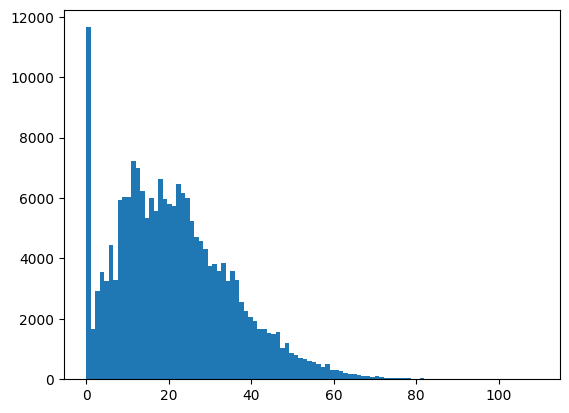

In [11]:
plt.hist(y[:10,:].flatten(), bins=100)
plt.show()

## AE training test

In [3]:
from src.models.sparse_autoencoder import *
from src.models.autoencoder import *
from src.functions.ae_training import *
from src.visualization.plotting import *

n_samples = 1000
latent_dim = 150
model_depth = 2
complexity = 'high'

################################

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device.type == 'cuda':
    # specify the gpu id
    torch.cuda.set_device(1)
    print('Using GPU', torch.cuda.current_device())

# set a random seed
seed = 0

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

################################

# load the data

data_dir = '/projects/heads/data/simulation/singlecell/'

for seed in range(10):
    if seed == 0:
        rna_counts = torch.load(data_dir+'large_{}-complexity_rs{}_y.pt'.format(complexity, seed),weights_only=False)
    else:
        temp = torch.load(data_dir+'large_{}-complexity_rs{}_y.pt'.format(complexity, seed),weights_only=False)
        rna_counts = torch.cat((rna_counts, temp), dim=0)
# now subsample the data if necessary
if n_samples < rna_counts.shape[0]:
    rna_counts = rna_counts[:n_samples]
rna_counts = rna_counts.to(device)
n_samples_validation = int(n_samples*0.1)

################################

Using GPU 1


100%|██████████| 10000/10000 [01:29<00:00, 112.11it/s]


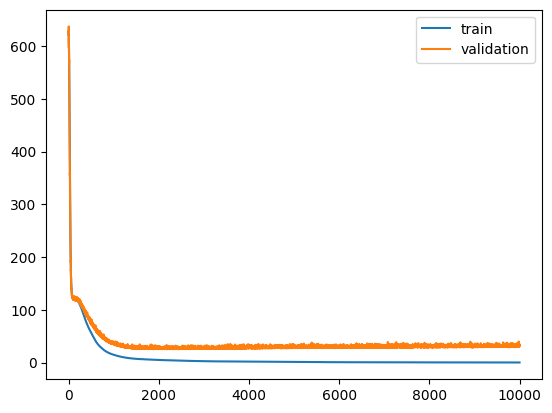

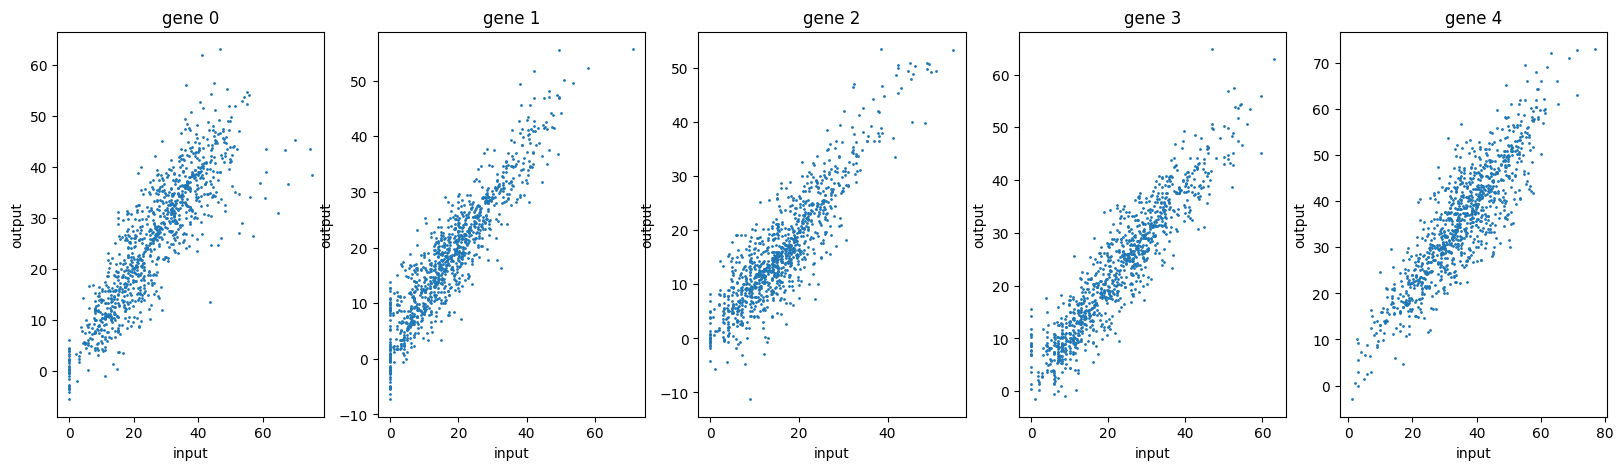

In [4]:
latent_dim = 150
model_depth = 2
dropout_rate = 0.0

encoder = Encoder(20000, latent_dim, model_depth).to(device)
decoder = Decoder(latent_dim, 20000, model_depth).to(device)

encoder, decoder, history = train_and_eval_model(encoder, decoder, rna_counts, n_samples, n_samples_validation, n_epochs=10000, plotting=True)

100%|██████████| 10000/10000 [01:31<00:00, 108.89it/s]


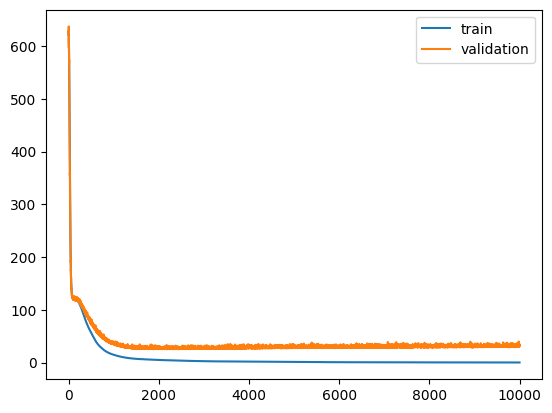

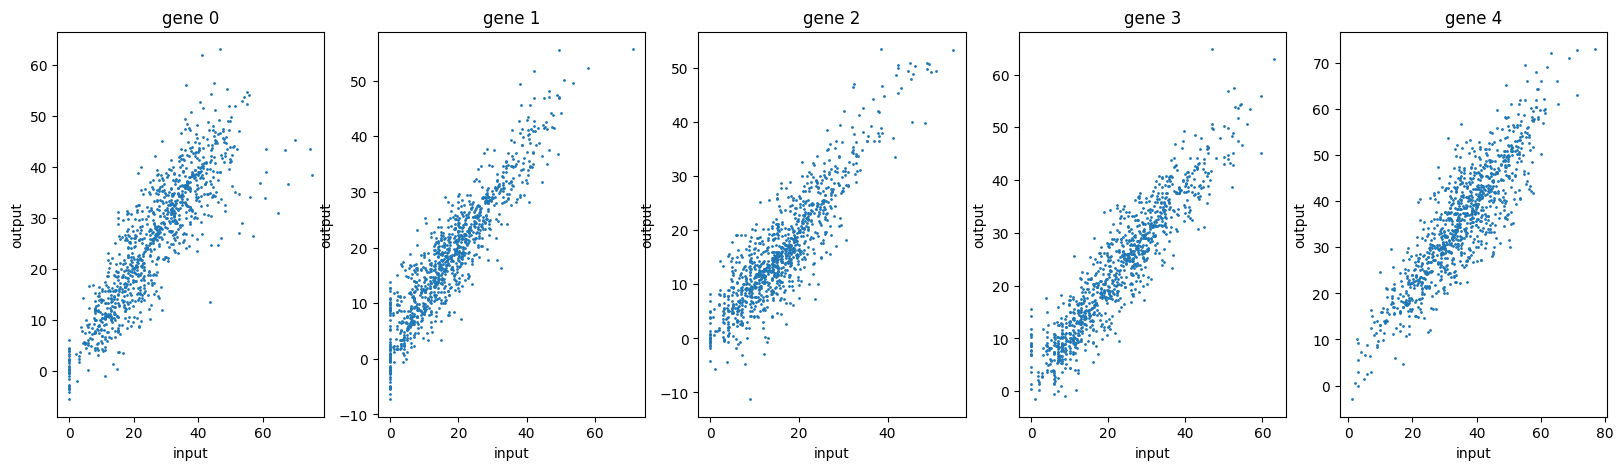

In [4]:
latent_dim = 150
model_depth = 2
dropout_rate = 0.1

encoder = Encoder(20000, latent_dim, model_depth).to(device)
decoder = Decoder(latent_dim, 20000, model_depth).to(device)

encoder, decoder, history = train_and_eval_model(encoder, decoder, rna_counts, n_samples, n_samples_validation, n_epochs=10000, plotting=True)

100%|██████████| 10000/10000 [01:31<00:00, 109.35it/s]


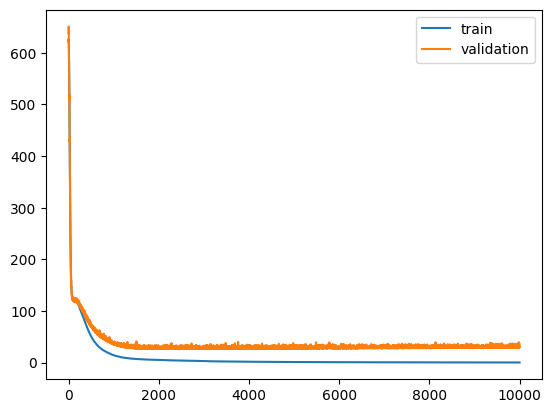

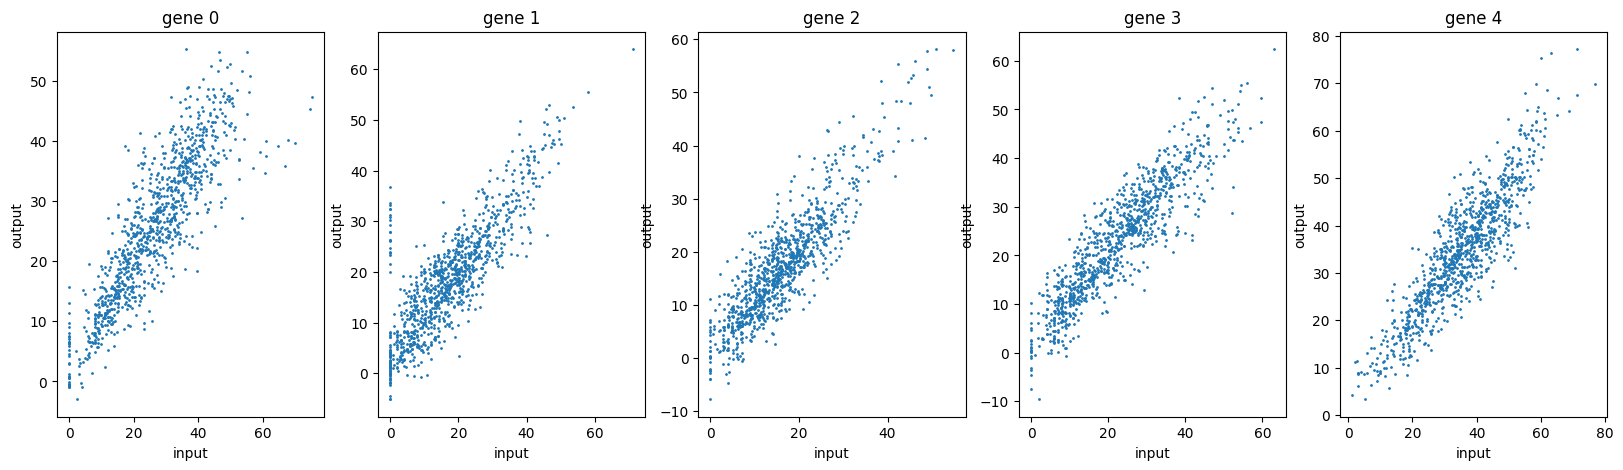

In [5]:
latent_dim = 150
model_depth = 2
dropout_rate = 0.5

encoder = Encoder(20000, latent_dim, model_depth).to(device)
decoder = Decoder(latent_dim, 20000, model_depth).to(device)

encoder, decoder, history = train_and_eval_model(encoder, decoder, rna_counts, n_samples, n_samples_validation, n_epochs=10000, plotting=True)

In [3]:
from src.models.sparse_autoencoder import *
from src.models.autoencoder import *
from src.functions.ae_training import *
from src.visualization.plotting import *

n_samples = 10000
latent_dim = 150
model_depth = 2
complexity = 'high'

################################

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device.type == 'cuda':
    # specify the gpu id
    torch.cuda.set_device(1)
    print('Using GPU', torch.cuda.current_device())

# set a random seed
seed = 0

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

################################

# load the data

data_dir = '/projects/heads/data/simulation/singlecell/'

for seed in range(10):
    if seed == 0:
        rna_counts = torch.load(data_dir+'large_{}-complexity_rs{}_y.pt'.format(complexity, seed),weights_only=False)
    else:
        temp = torch.load(data_dir+'large_{}-complexity_rs{}_y.pt'.format(complexity, seed),weights_only=False)
        rna_counts = torch.cat((rna_counts, temp), dim=0)
# now subsample the data if necessary
if n_samples < rna_counts.shape[0]:
    rna_counts = rna_counts[:n_samples]
rna_counts = rna_counts.to(device)
n_samples_validation = int(n_samples*0.1)

################################

Using GPU 1


  0%|          | 11/10000 [00:00<13:23, 12.43it/s]

100%|██████████| 10000/10000 [31:35<00:00,  5.28it/s]


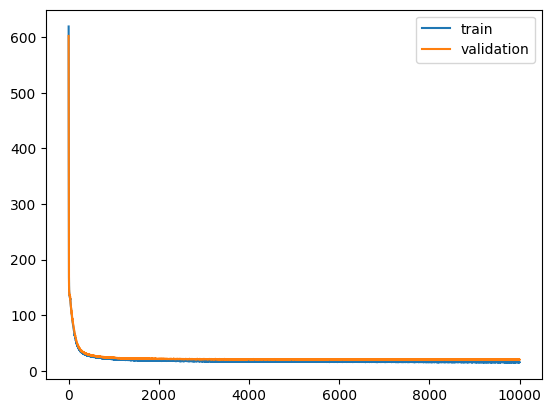

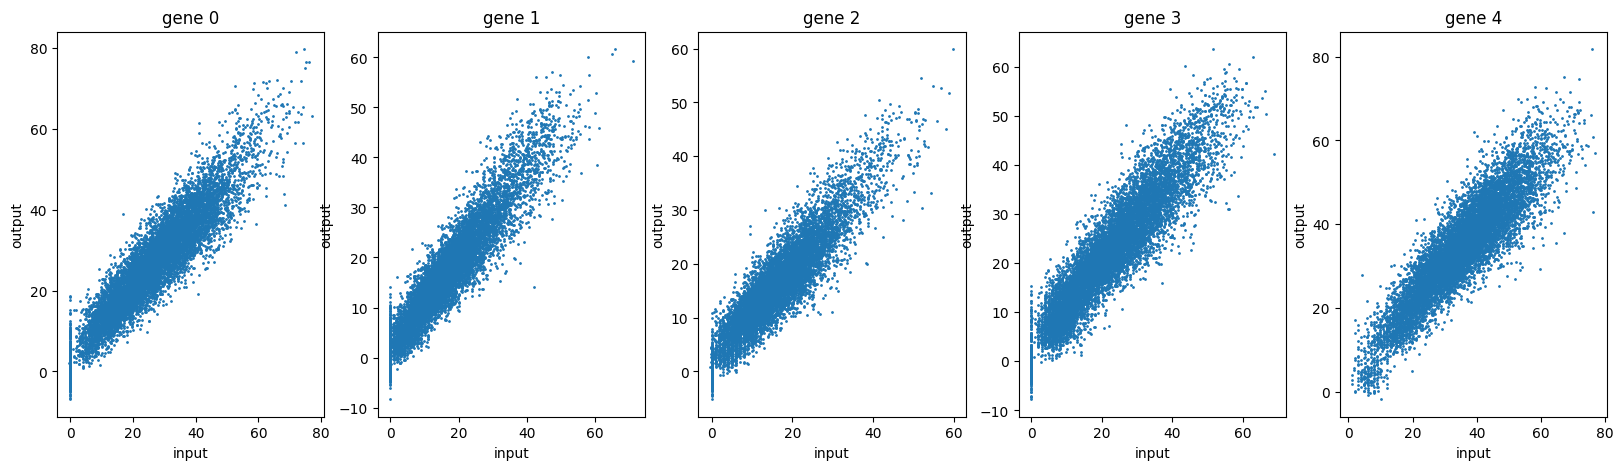

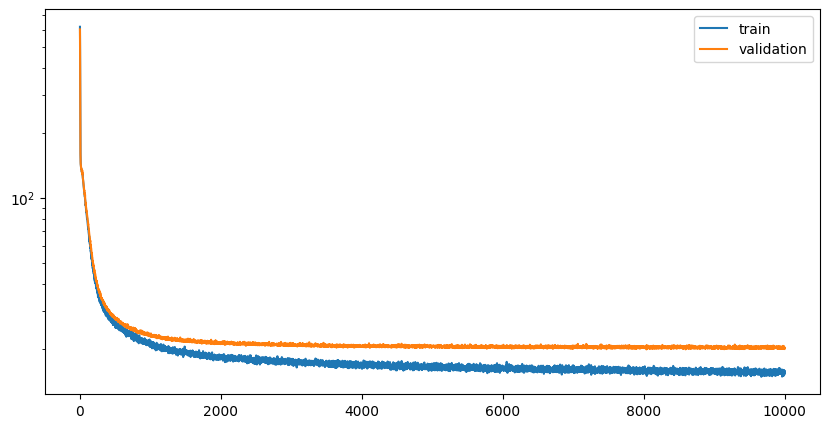

In [8]:
latent_dim = 150
model_depth = 2
dropout_rate = 0.1

encoder = Encoder(20000, latent_dim, model_depth, dropout=dropout_rate).to(device)
decoder = Decoder(latent_dim, 20000, model_depth, dropout=dropout_rate).to(device)

encoder, decoder, history = train_and_eval_model(encoder, decoder, rna_counts, n_samples, n_samples_validation, n_epochs=10000, plotting=True)
# also plot the history with log scale
fig, ax = plt.subplots(1,1, figsize=(10,5))
plt.plot(history['train_loss'], label='train')
plt.plot(history['val_loss'], label='validation')
plt.yscale('log')
plt.legend()
plt.show()

In [10]:
# save this model as the best one
model_name = 'large_{}-complexity_{}-depth_{}-latent_{}-samples_0.1-dropout'.format(complexity, model_depth, latent_dim, n_samples)

torch.save(encoder, '03_results/models/sim2_'+model_name+'_encoder.pth')
torch.save(decoder, '03_results/models/sim2_'+model_name+'_decoder.pth')

# also save the history of the training
history.to_csv('03_results/models/sim2_'+model_name+'_history.csv', index=False)

  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [32:52<00:00,  5.07it/s]


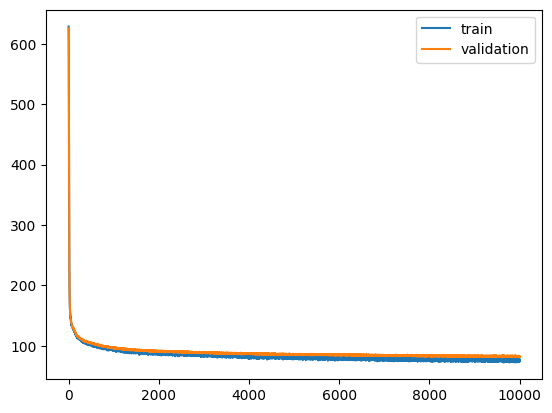

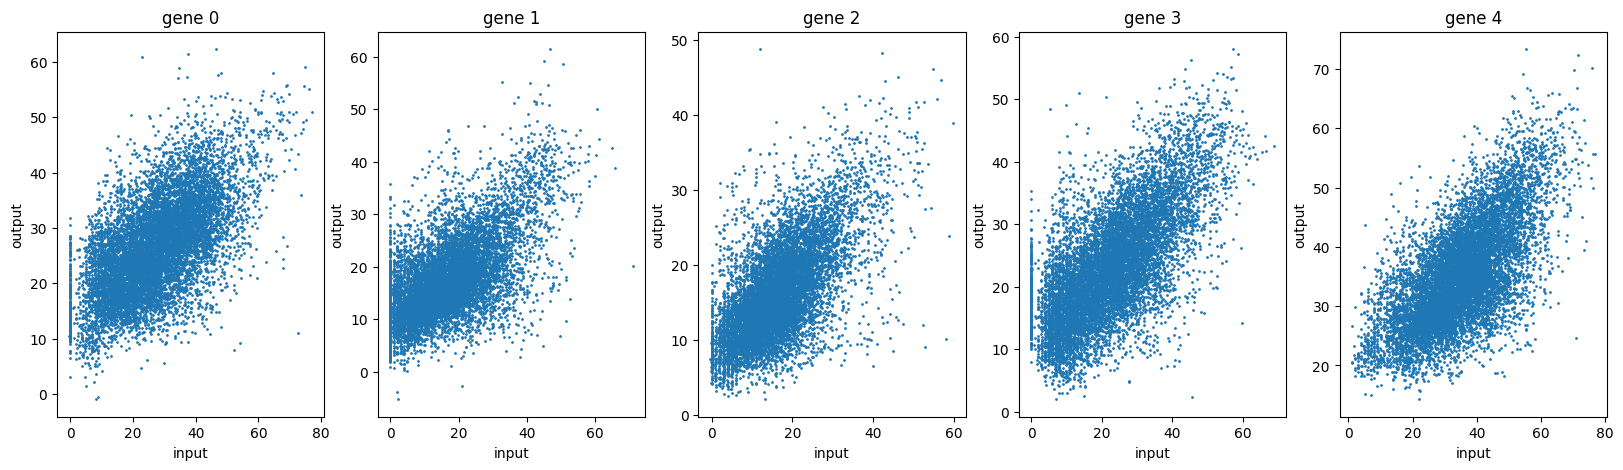

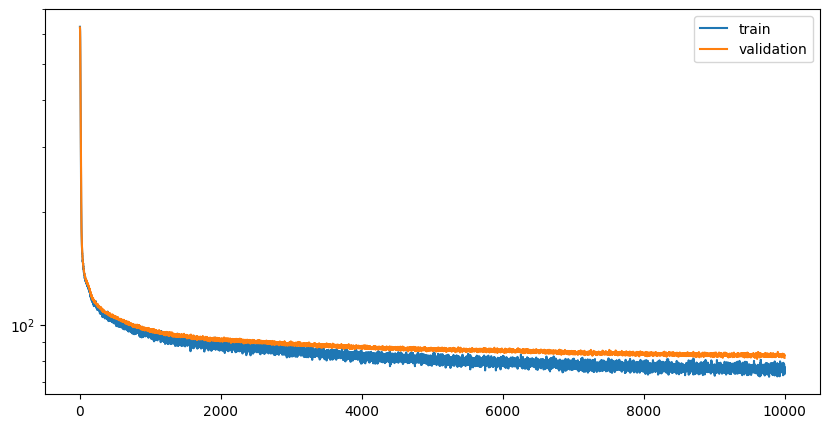

In [12]:
latent_dim = 20
model_depth = 2
dropout_rate = 0.1

encoder = Encoder(20000, latent_dim, model_depth, dropout=dropout_rate).to(device)
decoder = Decoder(latent_dim, 20000, model_depth, dropout=dropout_rate).to(device)

encoder, decoder, history = train_and_eval_model(encoder, decoder, rna_counts, n_samples, n_samples_validation, n_epochs=10000, plotting=True)
# also plot the history with log scale
fig, ax = plt.subplots(1,1, figsize=(10,5))
plt.plot(history['train_loss'], label='train')
plt.plot(history['val_loss'], label='validation')
plt.yscale('log')
plt.legend()
plt.show()

# save this model as the best one
model_name = 'large_{}-complexity_{}-depth_{}-latent_{}-samples_0.1-dropout'.format(complexity, model_depth, latent_dim, n_samples)

torch.save(encoder, '03_results/models/sim2_'+model_name+'_encoder.pth')
torch.save(decoder, '03_results/models/sim2_'+model_name+'_decoder.pth')

# also save the history of the training
history.to_csv('03_results/models/sim2_'+model_name+'_history.csv', index=False)

100%|██████████| 10000/10000 [2:12:15<00:00,  1.26it/s] 


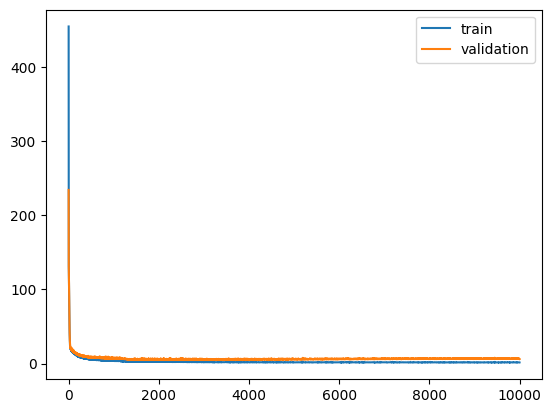

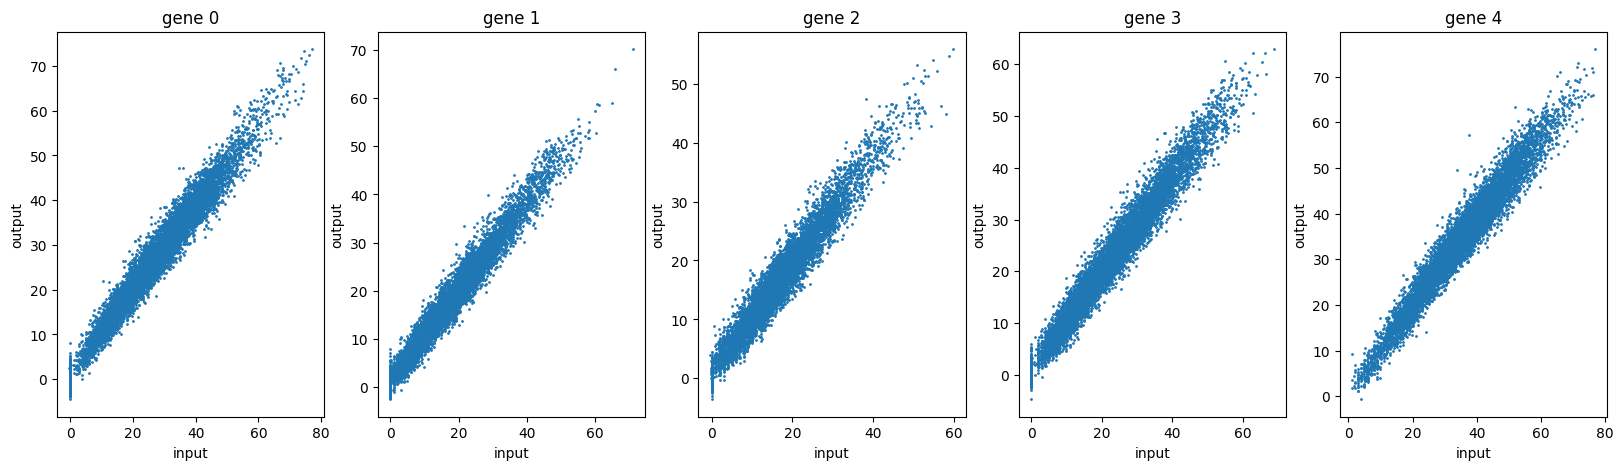

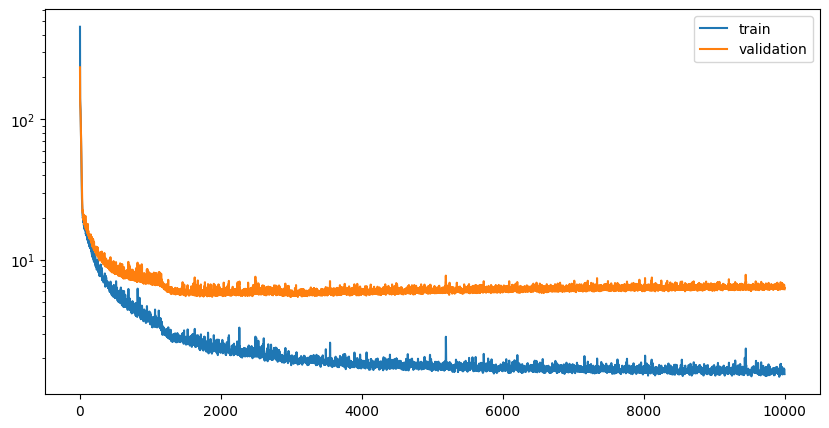

In [13]:
latent_dim = 1000
model_depth = 2
dropout_rate = 0.1

encoder = Encoder(20000, latent_dim, model_depth, dropout=dropout_rate).to(device)
decoder = Decoder(latent_dim, 20000, model_depth, dropout=dropout_rate).to(device)

encoder, decoder, history = train_and_eval_model(encoder, decoder, rna_counts, n_samples, n_samples_validation, n_epochs=10000, plotting=True)
# also plot the history with log scale
fig, ax = plt.subplots(1,1, figsize=(10,5))
plt.plot(history['train_loss'], label='train')
plt.plot(history['val_loss'], label='validation')
plt.yscale('log')
plt.legend()
plt.show()

# save this model as the best one
model_name = 'large_{}-complexity_{}-depth_{}-latent_{}-samples_0.1-dropout'.format(complexity, model_depth, latent_dim, n_samples)

torch.save(encoder, '03_results/models/sim2_'+model_name+'_encoder.pth')
torch.save(decoder, '03_results/models/sim2_'+model_name+'_decoder.pth')

# also save the history of the training
history.to_csv('03_results/models/sim2_'+model_name+'_history.csv', index=False)